### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2018 ###

# Smart Grid #

#### Bryan Luu (email address), Saniya Khullar (email address), and In Young Cho (icho3@wisc.edu)

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)
[discussion 1](#Case-Simpliest-Discussion-1)

## 1. Introduction ##

The first few sentences should give a quick overview of the entire project. Then, elaborate with a description of the problem that will be solved, a brief history (with [citations](https://en.wikipedia.org/wiki/Citation)) of how the problem came about, why it's important/interesting, and any other interesting facts you'd like to talk about. You should address and explain where the problem data is coming from (research? the internet? synthetically generated?) Also give an outline of the rest of the report.

This section should be 300-600 words long, and **should be accessible to a general audience** (don't assume your reader has taken the class!). Feel free to include images if you think it'll be helpful:
![fixit flowchart][flow]

For more help on using Markdown, see [this reference](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet).

[flow]: https://s-media-cache-ak0.pinimg.com/736x/f5/75/c5/f575c53b93724808c6f0211890a54900.jpg

Gradual development of the problem
1. **(Case simplest)** When there is no batteries and no conventional power grid is used. This case is only possible when the power producers can supply enough power for all power demands.
2. **(Case maingrid)** When there is no batteries but conventional power grid may supply any shortage from the power producers of a day. However, there will be penalized for the usage of non-environmental power generating sources.
3. **(Case battery)** When there is a type of batteries installed at each non-powering households and power grid may be used.
4. **(Case earning)** When villegers are 

## 2. Mathematical model ##

A discussion of the modeling assumptions made in the problem (e.g. is it from physics? economics? something else?). Explain the decision variables, the constraints, and the objective function. Finally, show the optimization problem written in standard form. Discuss the model type (LP, QP, MIP, etc.). Equations should be formatted in $\\LaTeX$ within the IJulia notebook. For this section you may **assume the reader is familiar with the material covered in class**.

Here is an example of an equation:

$$\begin{bmatrix}
      1 & 2 \\
       3 & 4
    \end{bmatrix}
    \begin{bmatrix} x \\ y \end{bmatrix} =
    \begin{bmatrix} 5 \\ 6 \end{bmatrix}$$

And here is an example of an optimization problem in standard form:
$$\begin{aligned}
  \underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& f_0(x) \\
    \text{subject to:}\qquad& f_i(x) \le 0 && i=1,\dots,m\\
    & h_j(x) = 0 && j=1,\dots,r
    \end{aligned}$$

For some quick tips on using $\LaTeX$, see [this cheat sheet](http://users.dickinson.edu/~richesod/latex/latexcheatsheet.pdf).

Throughout the mathematical model, the following terms are used in common.

\begin{equation*}
Nodes = \text{The set of nodes in the problem} \\% including power-consuming households, power-generating households, power generators and conventional main grid connection} \\
n = \text{A node in the set of nodes at a day in the time window} \in Nodes \\
Edges = \text{The set of edges in the problem} \\
(i, j) = \text{An edge where from node $i$ to node $j$} \in Edges \\
SustainDays = \text{Days when the main power grid is not necessary to supply energy to the village} \\
Days = \text{The observing/optimizing time window} \\
AddDays = \text{The observing/optimizing time window and one additional day} \\
t = \text{A day} \in SustainDays \subseteq Days \subset AddDays \\
x = \begin{bmatrix}
x_{ij, t} \\
\end{bmatrix} = \begin{bmatrix}
\text{Power flow from node $i$ to node $j$ in day $t$} \\
\end{bmatrix} \forall (i, j) \in Edges, t \in Days \\
d_{ij} = \text{Distance between nodes $i$ and $j$} \geq 0 \\
r_{loss} = \text{Energy loss rate on edge $(i, j)$ that is proportional to the distance $d_{ij}$} \\
\begin{aligned}
P(x_{ij, t}) &= \text{Power received at node $j$ after losing a portion of sent power at node $i$ on day $t$} \\
&= (1 - r_{loss}d_{ij})x_{ij} \\
\end{aligned} \\
p_{n, t} = \text{Power production at node $n$ on day $t$} \\
c_{n, t} = \text{Power required at node $n$ on day $t$} \\
\begin{aligned}
b_{n, t} &= \text{Supply/demand at node $n$ on day $t$} \\
&= p_{n, t} - c_{n, t} \\
\end{aligned} \\
\mu = \text{Penalty on the use of main grid} \\
s = \begin{bmatrix}
s_{n, t} \\
\end{bmatrix} = \begin{bmatrix}
\text{Energy stored at a battery at node $n$ at the start of the day $t$} \\
\end{bmatrix} \\
b_{c} = \text{Battery capacity} \\
\lambda_{in} = \text{Efficiency of charging battery} \\
\lambda_{out} = \text{Efficiency of using battery power} \\
\end{equation*}

In [1]:
# Data
using NamedArrays

nodes = [:S, :K, :P, :gamma, :L, :B, :O, :beta, :C, :M, :R, :alpha]
us = [:K, :L, :C]
producers = [us..., :gamma, :beta, :alpha]
consumers = [:S, :K, :P, :L, :B, :O, :C, :M, :R]

arcs = [(:K, :P), (:S, :P), (:P, :L), (:P, :gamma), 
    (:gamma, :B), (:gamma, :L), (:gamma, :R), (:L, :B), (:B, :O),
    (:O, :beta), (:beta, :R), (:beta, :C), (:beta, :M),
    (:alpha, :gamma), (:alpha, :S), (:alpha, :R)]
arcs = [arcs; [(j, i) for (i, j) in arcs]]

dist_vec = [1, 2, 6, 3, 4, 5, 7, 5, 3, 4, 2, 2, 3, 5, 5, 5]*100
distance = Dict(zip(arcs, [dist_vec; dist_vec]))

days = [1:7;]

loss = 0.0005

matrix = zeros(length(consumers), length(days))
demand = NamedArray(matrix, (consumers, days), ("Consumer","Day"))
demand[:S, :] = [40.8, 100, 230.5, 150.8, 74.2, 97.3, 65.4]
demand[:P, :] = [37.8, 30.3, 28.8, 20.5, 37, 45, 29.6]
demand[:K, :] = repeat([27.3], length(days));
demand[:L, :] = [30.1, 28.8, 27.3, 55.2, 64, 42, 36.6]
demand[:C, :] = [30, 35.5, 31.2, 45.5, 50, 43.1, 38.4]
demand[:B, :] = [30.1, 31.5, 30.1, 35.1, 34.3, 39, 33.2]
demand[:O, :] = [23.7, 28.3, 16.4, 36.7, 20, 17.3, 11.1]
demand[:M, :] = [27.3, 21.9, 24.6, 28.9, 26, 30.7, 23.8]
demand[:R, :] = [19.2, 20.5, 20.5, 20, 18.4, 21.3, 20.5]

matrix = zeros(length(producers), length(days))
supply = NamedArray(matrix, (producers, days), ("Producer","Day"))
supply[:alpha, :] = [600, 300, 700, 0, 100, 0, 350]
supply[:beta, :] = [500, 200, 900, 0, 50, 0, 300]
supply[:L, :] = [150, 200, 150, 305, 200, 30, 500]
supply[:K, :] = [200, 150, 100, 600, 150, 40, 200]
supply[:C, :] = [150, 230, 180, 120, 40, 20, 140]
supply[:gamma, :] .= 10000;

matrix = zeros(length(nodes), length(days))
b = NamedArray(matrix, (nodes, days), ("Nodes", "Day"))
for n in nodes
    for t in days
        if !(n in producers)
            b[n, t] = -demand[n, t]
        elseif !(n in consumers)
            b[n, t] = supply[n, t]
        else
            b[n, t] = supply[n, t] - demand[n, t]
        end
    end
end

# punishment for using gamma
µ = [0.01, 0.07, 0.22;];

# battery capacities
cap = Dict(zip(nodes, zeros(length(nodes))))
for c in consumers
    cap[c] = 20;
end
cap[:S] = 100;

# battery efficiency
eff_in = 0.6;
eff_out = 0.8;

In [2]:
using GraphPlot, LightGraphs, Colors

# Plots the graph of the flows
# flow is a dictionary of arcs -> flows
# Green nodes represents energy-giving nodes, Red nodes represents energy-taking nodes, Gray nodes are neutral nodes.
# Green edges means energy flows there
# Labels appear at the destination of nodes
function plot_flow(flow)
    
N = length(nodes)
E = length(arcs)
nodemap = Dict(zip(nodes, 1:N))
g = SimpleDiGraph(N)
for (i,j) in arcs
    add_edge!(g, nodemap[i], nodemap[j])
end
                                                            
inflows = Dict(zip(nodes, [sum(flow[(i,j)] for (i,j) in arcs if j == k) for k in nodes]))
outflows = Dict(zip(nodes, [sum(flow[(i,j)] for (i,j) in arcs if i == k) for k in nodes]))
                                                                                        
# vector of net outflows for each node
net_outflows = [outflows[k] - inflows[k] for k in nodes]

# color nodes in proportion to their net outflows                                                            
l, u = min(net_outflows...), max(net_outflows...) # lower and upper bounds on the colors
node_colors = [(c > 0 ? RGBA(0.5*(1-c/u), 0.5*(1+c/u), 0.5*(1-c/u), 1) 
        : RGBA(0.5*(1+c/l), 0.5*(1-c/l), 0.5*(1-c/l), 1)) for c in net_outflows]

# sort arcs by their tuple of numerical node indices
arcmap = sort(arcs, by=(n -> (nodemap[n[1]], nodemap[n[2]])))

# locations of the nodes, note that y is reversed
locs_x = [0, 0.5, 1, 2, 4, 3.5, 4, 2, 1.5, 3, 1, 0]
locs_y = -[0, -0.5, 0, 1, 0, 2, 3, 3, 4, 4, 3.5, 2]
    
# color the edges in proportion to their flow
maxflow = max([flow[a] for a in arcs]...)
lg = colorant"lightgray" # lightgray
dominant_flows = Dict(zip(arcs, [max(flow[(i,j)], flow[(j,i)]) for (i,j) in arcs]))
edge_colors = [(dominant_flows[a] > 0 ? RGBA(lg.r*(1-dominant_flows[a]/maxflow), 
        dominant_flows[a]*(1-lg.g)/maxflow + lg.g, 
        lg.b*(1-dominant_flows[a]/maxflow), 1) : lg) for a in arcmap]
    
# plot graph
gplot(g, nodelabel=[(n in producers ? String(n)*"*" : n) for n in nodes], locs_x, locs_y,
    edgelabel=[(flow[a] > 0 ? string(round(flow[a],1)) : "") for a in arcmap], 
    arrowlengthfrac=0, edgelabeldistx=0, edgelabeldisty=0,
    nodefillc=node_colors, edgestrokec=edge_colors, NODESIZE=0.05)
                                                            
end
                                                        
# flow = Dict(zip(arcs, [getvalue(x[a, day]) for a in arcs]))

# plot_flow(flow)

plot_flow (generic function with 1 method)

## 2.1 Mathematical model **(case simplest)** ##

This simpliest case considers when solar panels and wind turbines are the only sources of energy for a day and no conventional main grid or batteries are taken into account. Because there is no battery used in this case, no energy can be stored for the next day, meaning all the energy demands must be met using the energy sources. And it is possible not to use $\gamma$ as long as solar panels and wind turbines can supply enough energy to feed the energy demands of the whole villgae of a day. Therefore, this case will be considered only on day 1 through day 5.

\begin{equation*}
SustainDays = \{1, 2, 3, 4, 5\} \\
b_{\gamma, t} = 0 \quad\forall t \in SustainDays \\
\end{equation*}

The data available in this case are energy demand from a node $n$ at a day $t$, namely $c_{n, t}$, energy supply from the node of the day, $p_{n, t}$, distances of edges $d_{ij}$. From these data, the flow on edges $x_{ij}$ are decision variables to be decided on for every days in $Days_{simplest}$.

\begin{equation*}
x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in SustainDays \\
\end{equation*}

And the objective would be optimizing the whole system by minimizing power loss on the transmission lines.

\begin{equation*}
\underset{x}{\min} \ \sum_{\substack{(i, j) \in Edges \\ t \in SustainDays}}r_{loss}d_{ij}x_{ij, t} \\
\end{equation*}

The only constraint attempts a balance between the sum of supplied and produced energy and the sum of demanded and distributed energy at every node. However, the constraint is not strict equality because there is no need to get maximum capacity of energy when the sum of demanded and distributed energy is not as much as the maximum capacity.

\begin{equation*}
\sum_{(i, k) \in Edges}P(x_{ik, t}) + p_{k, t} \geq \sum_{(k, j) \in Edges}x_{kj, t} + c_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
-\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} \leq b_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
\end{equation*}

Then, this case becomes the following mathematical model.

\begin{align*}
\underset{x}{\min} \ & \sum_{\substack{(i, j) \in Edges \\ t \in SustainDays}}r_{loss}d_{ij}x_{ij, t} \\
\text{s.t.} \ & -\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} \leq b_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
& b_{\gamma, t} = 0 \quad\forall t \in SustainDays \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in SustainDays \\
\end{align*}

In the codes to solve this case, the following terms are renamed.

\begin{equation*}
\sum_{\substack{(i, j) \in Edges \\ t \in SustainDays}}r_{loss}d_{ij}x_{ij, t} = {\tt{energy\_lost}} \\
\sum_{(i, k) \in Edges}P(x_{ik, t}) = {\tt{flow\_in[k, t]}} \quad\forall k \in Nodes, t \in SustainDays \\
\sum_{(k, j) \in Edges}x_{kj, t} = {\tt{flow\_out[k, t]}} \quad\forall k \in Nodes, t \in SustainDays \\
-\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} = {\tt{net\_outflow[k, t]}} \quad\forall k \in Nodes, t \in SustainDays \\
\end{equation*}

And the following is what actual model in codes looks like.

\begin{align*}
\underset{x}{\min} \ & {\tt{energy\_lost}} \\
\text{s.t.} \ & {\tt{net\_outflow[k, t]}} \leq b_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
& {\tt{net\_outflow[\gamma, t]}} \leq b_{\gamma, t} = 0 \quad\forall t \in SustainDays \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in SustainDays \\
\end{align*}

------Solution------
x: 2 dimensions:
[        (:K, :P),:]
  [        (:K, :P),1] = 87.50877192982455
  [        (:K, :P),2] = 122.7
  [        (:K, :P),3] = 72.7
  [        (:K, :P),4] = 197.953216374269
  [        (:K, :P),5] = 122.7
[        (:S, :P),:]
  [        (:S, :P),1] = 0.0
  [        (:S, :P),2] = 0.0
  [        (:S, :P),3] = 0.0
  [        (:S, :P),4] = 0.0
  [        (:S, :P),5] = 0.0
[        (:P, :L),:]
  [        (:P, :L),1] = 0.0
  [        (:P, :L),2] = 0.0
  [        (:P, :L),3] = 0.0
  [        (:P, :L),4] = 0.0
  [        (:P, :L),5] = 0.0
[    (:P, :gamma),:]
  [    (:P, :gamma),1] = 0.0
  [    (:P, :gamma),2] = 0.0
  [    (:P, :gamma),3] = 0.0
  [    (:P, :gamma),4] = 0.0
  [    (:P, :gamma),5] = 0.0
[    (:gamma, :B),:]
  [    (:gamma, :B),1] = 0.0
  [    (:gamma, :B),2] = 0.0
  [    (:gamma, :B),3] = 0.0
  [    (:gamma, :B),4] = 0.0
  [    (:gamma, :B),5] = 0.0
[    (:gamma, :L),:]
  [    (:gamma, :L),1] = 0.0
  [    (:gamma, :L),2] = 0.0
  [    (:gamma, :L),3

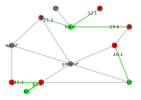

Day 1

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:436
while loading In[18], in expression starting on line 30


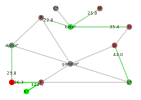

Day 2

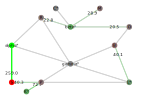

Day 3

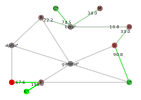

Day 4

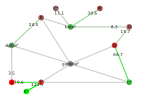

Day 5

In [18]:
# Model: case simpliest
using Clp, JuMP

sustaindays = days[1:5];

m_simplest = Model(solver=ClpSolver())

@variable(m_simplest, x[arcs, sustaindays] >= 0) # energy flow from node i to j

# Useful expressions
#@expression(m, flow_in_lossless[k in nodes, t in sustaindays], 
#    sum(x[(i,j), t] for (i,j) in arcs if j == k))
@expression(m_simplest, flow_in[k in nodes, t in sustaindays], 
    sum((1-loss*distance[(i,j)])*x[(i,j), t] for (i,j) in arcs if j == k))
@expression(m_simplest, flow_out[k in nodes, t in sustaindays], 
    sum(x[(i,j), t] for (i,j) in arcs if i == k))
@expression(m_simplest, energy_lost, sum(loss*distance[a]*x[a, t] for a in arcs for t in sustaindays))
@expression(m_simplest, net_outflow[k in nodes, t in sustaindays], flow_out[k, t] - flow_in[k, t])
                                
@constraint(m_simplest, power_balance[k in nodes, t in sustaindays], net_outflow[k, t] <= b[k, t])
@constraint(m_simplest, power_balance_simplest[t in sustaindays], net_outflow[:gamma, t] <= 0)
                                                                
@objective(m_simplest, Min, energy_lost)
                                                
status = solve(m_simplest)

println("------Solution------")
println(getvalue(x))
println("Total energy losses will be ", getvalue(energy_lost), " kWh.")
for day in sustaindays
    #figure();
    flow = Dict(zip(arcs, [getvalue(x[a, day]) for a in arcs]))
    print("Day ", day)
    display(plot_flow(flow))
end
#plot_flow(Dict(zip(arcs, [getvalue(x[a, 1]) for a in arcs])))
#plot_flow(Dict(zip(arcs, [getvalue(x[a, 2]) for a in arcs])))
#plot_flow(Dict(zip(arcs, [getvalue(x[a, 3]) for a in arcs])))


### Additional discussion: case simplest ###

If the constraint in the case simpliest has equality instead of inequality, that forces all power generators to supply as much as it can for the day. And this excess energy would float on the network because no node can consume more than what it has demanded.

It can be visualized by the following mathematical model.

\begin{align*}
\underset{x}{\min} \ & \sum_{\substack{(i, j) \in Edges \\ t \in SustainDays}}r_{loss}d_{ij}x_{ij, t} \\
\text{s.t.} \ & -\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} = b_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
& b_{\gamma, t} = 0 \quad\forall t \in SustainDays \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in SustainDays \\
\end{align*}

And the following is the actual model in codes.

\begin{align*}
\underset{x}{\min} \ & {\tt{energy\_lost}} \\
\text{s.t.} \ & {\tt{net\_outflow[k, t]}} = b_{k, t} \quad\forall k \in Nodes, t \in SustainDays \\
& {\tt{net\_outflow[\gamma, t]}} \leq b_{\gamma, t} = 0 \quad\forall t \in SustainDays \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in SustainDays \\
\end{align*}

In [25]:
# Model: case simpliest additional discussion
using Clp, JuMP

sustaindays = days[1:5];

m_simplest_discussion = Model(solver=ClpSolver())

@variable(m_simplest_discussion, x[arcs, sustaindays] >= 0) # energy flow from node i to j

# Useful expressions
@expression(m_simplest_discussion, flow_in[k in nodes, t in sustaindays], 
    sum((1-loss*distance[(i,j)])*x[(i,j), t] for (i,j) in arcs if j == k))
@expression(m_simplest_discussion, flow_out[k in nodes, t in sustaindays], 
    sum(x[(i,j), t] for (i,j) in arcs if i == k))
@expression(m_simplest_discussion, energy_lost, sum(loss*distance[a]*x[a, t] for a in arcs for t in sustaindays))
@expression(m_simplest_discussion, net_outflow[k in nodes, t in sustaindays], flow_out[k, t] - flow_in[k, t])
                                
@constraint(m_simplest_discussion, power_balance[k in nodes, t in sustaindays], net_outflow[k, t] == b[k, t])
@constraint(m_simplest_discussion, power_balance_simplest[t in sustaindays], net_outflow[:gamma, t] == 0)
                                                                
@objective(m_simplest_discussion, Min, energy_lost)
                                                
status = solve(m_simplest_discussion)

println("------Solution------")
println(getvalue(x))
println("Total energy losses will be ", getvalue(energy_lost), " kWh.")
for day in sustaindays
    flow = Dict(zip(arcs, [getvalue(x[a, day]) for a in arcs]))
    print("Day ", day)
    display(plot_flow(flow))
end

------Solution------
x: 2 dimensions:
[        (:K, :P),:]
  [        (:K, :P),1] = NaN
  [        (:K, :P),2] = NaN
  [        (:K, :P),3] = NaN
  [        (:K, :P),4] = NaN
  [        (:K, :P),5] = NaN
[        (:S, :P),:]
  [        (:S, :P),1] = NaN
  [        (:S, :P),2] = NaN
  [        (:S, :P),3] = NaN
  [        (:S, :P),4] = NaN
  [        (:S, :P),5] = NaN
[        (:P, :L),:]
  [        (:P, :L),1] = NaN
  [        (:P, :L),2] = NaN
  [        (:P, :L),3] = NaN
  [        (:P, :L),4] = NaN
  [        (:P, :L),5] = NaN
[    (:P, :gamma),:]
  [    (:P, :gamma),1] = NaN
  [    (:P, :gamma),2] = NaN
  [    (:P, :gamma),3] = NaN
  [    (:P, :gamma),4] = NaN
  [    (:P, :gamma),5] = NaN
[    (:gamma, :B),:]
  [    (:gamma, :B),1] = NaN
  [    (:gamma, :B),2] = NaN
  [    (:gamma, :B),3] = NaN
  [    (:gamma, :B),4] = NaN
  [    (:gamma, :B),5] = NaN
[    (:gamma, :L),:]
  [    (:gamma, :L),1] = NaN
  [    (:gamma, :L),2] = NaN
  [    (:gamma, :L),3] = NaN
  [    (:gamma, :L),4] =

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] watch_stream(::Base.PipeEndpoint, ::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:111
 [7] (::IJulia.##21#23)() at ./task.jl:335
while loading In[25], in expression starting on line 27


Total energy losses will be NaN kWh.


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:436
while loading In[25], in expression starting on line 28


Day 1

LoadError: [91mInexactError()[39m

## 2.2 Mathematical model **(case maingrid)** ##

Now, let $\gamma$ be used when there is an energy shortage due to the incapability of energy producers to supply enough energy for demands of a day. From the data, there is a energy shortage on day 6 when $b_{\gamma, 6} \neq 0$. Therefore, let's consider all the days in $Days$ to optimize how to distribute energy throughout the village.

In this case, there is no change in decision variables because there is no change in the network except that now $\gamma$ may supply energy.

\begin{equation*}
x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in Days \\
\end{equation*}

The village wants to discourage the usage of $\gamma$ from supplying energy as the energy source would be likely non-environmental. Therefore, there would be a penalty for the energy from $\gamma$, which is proportional to the amount of energy. Let the penalizing rate be denoted by $\mu$. Then, the optimization problem needs to minimize the penalty as well as the energy loss in the network. Therefore, the new objective function becomes the following.

\begin{equation*}
\underset{x}{\min} \ \sum_{\substack{(i, j) \in Edges \\ t \in Days}}r_{loss}d_{ij}x_{ij, t} + \mu\sum_{\substack{(\gamma, j) \in Edges \\ t \in Days}}x_{\gamma j, t} \\
\end{equation*}

Also, there is no change in the energy-balancing constraint. However, there is no longer the constraint $b_{\gamma, t} = 0$.

\begin{equation*}
-\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} \leq b_{k, t} \quad\forall k \in Nodes, t \in Days \\
\end{equation*}

The following summarizes the mathematical model of this case.

\begin{align*}
\underset{x}{\min} \ & \sum_{\substack{(i, j) \in Edges \\ t \in Days}}r_{loss}d_{ij}x_{ij, t} + \mu\sum_{\substack{(\gamma, j) \in Edges \\ t \in Days}}x_{\gamma j, t} \\
\text{s.t.} \ & -\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} \leq b_{k, t} \quad\forall k \in Nodes, t \in Days \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in Days \\
\end{align*}

And there are new terms renamed in the codes.

\begin{equation*}
\sum_{\substack{(i, j) \in Edges \\ t \in Days}}r_{loss}d_{ij}x_{ij, t} = {\tt{energy\_lost}} \\
\sum_{(i, k) \in Edges}P(x_{ik, t}) = {\tt{flow\_in[k, t]}} \quad\forall k \in Nodes, t \in Days \\
\sum_{(k, j) \in Edges}x_{kj, t} = {\tt{flow\_out[k, t]}} \quad\forall k \in Nodes, t \in Days \\
-\sum_{(i, k) \in Edges}P(x_{ik, t}) + \sum_{(k, j) \in Edges}x_{kj, t} = {\tt{net\_outflow[k, t]}} \quad\forall k \in Nodes, t \in Days \\
\sum_{\substack{(\gamma, j) \in Edges \\ t \in Days}}x_{\gamma j, t} = {\tt{dirty\_power}} \\
\end{equation*}

Therefore, the above mathematical model becomes the following in the codes.

\begin{align*}
\underset{x}{\min} \ & {\tt{energy\_lost}} + \mu \times {\tt{dirty\_power}} \\
\text{s.t.} \ & {\tt{net\_outflow[k, t]}} \leq b_{k, t} \quad\forall k \in Nodes, t \in Days \\
& x_{ij, t} \geq 0 \quad\forall (i, j) \in Edges, t \in Days \\
\end{align*}

------Solution------
x: 2 dimensions:
[        (:K, :P),:]
  [        (:K, :P),1] = 87.50877192982455
  [        (:K, :P),2] = 122.7
  [        (:K, :P),3] = 72.7
  [        (:K, :P),4] = 197.953216374269
  [        (:K, :P),5] = 122.7
  [        (:K, :P),6] = 12.7
  [        (:K, :P),7] = 107.64912280701755
[        (:S, :P),:]
  [        (:S, :P),1] = 0.0
  [        (:S, :P),2] = 0.0
  [        (:S, :P),3] = 0.0
  [        (:S, :P),4] = 0.0
  [        (:S, :P),5] = 0.0
  [        (:S, :P),6] = 0.0
  [        (:S, :P),7] = 0.0
[        (:P, :L),:]
  [        (:P, :L),1] = 0.0
  [        (:P, :L),2] = 0.0
  [        (:P, :L),3] = 0.0
  [        (:P, :L),4] = 0.0
  [        (:P, :L),5] = 0.0
  [        (:P, :L),6] = 0.0
  [        (:P, :L),7] = 0.0
[    (:P, :gamma),:]
  [    (:P, :gamma),1] = 0.0
  [    (:P, :gamma),2] = 0.0
  [    (:P, :gamma),3] = 0.0
  [    (:P, :gamma),4] = 0.0
  [    (:P, :gamma),5] = 0.0
  [    (:P, :gamma),6] = 0.0
  [    (:P, :gamma),7] = 0.0
[    (:gamma, :B),

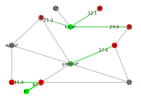

Day 1

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:436
while loading In[30], in expression starting on line 30


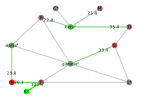

Day 2

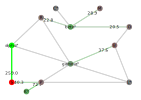

Day 3

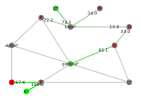

Day 4

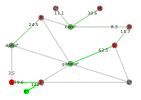

Day 5

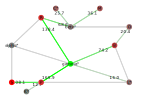

Day 6

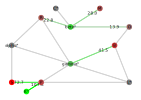

Day 7

In [30]:
# Model: case maingrid
using Clp, JuMP

m_maingrid = Model(solver=ClpSolver())

# dirty power penalty
p = 0.05;

@variable(m_maingrid, x[arcs, days] >= 0) # energy flow from node i to j

# Useful expressions
@expression(m_maingrid, flow_in[k in nodes, t in days], 
    sum((1-loss*distance[(i,j)])*x[(i,j), t] for (i,j) in arcs if j == k))
@expression(m_maingrid, flow_out[k in nodes, t in days], 
    sum(x[(i,j), t] for (i,j) in arcs if i == k))
@expression(m_maingrid, energy_lost, sum(loss*distance[a]*x[a, t] for a in arcs for t in days))
@expression(m_maingrid, dirty_power, sum(flow_out[:gamma, t] for t in days))
@expression(m_maingrid, net_outflow[k in nodes, t in days], flow_out[k, t] - flow_in[k, t])
                                
@constraint(m_maingrid, power_balance[k in nodes, t in days], net_outflow[k, t] <= b[k, t])
                                                                
@objective(m_maingrid, Min, energy_lost + p*dirty_power)
                                                
status = solve(m_maingrid)

println("------Solution------")
println(getvalue(x))
println("Total energy losses will be ", getvalue(energy_lost), " kWh.")
println("Total dirty energy used will be ", getvalue(dirty_power), " kWh.")
for day in days
    flow = Dict(zip(arcs, [getvalue(x[a, day]) for a in arcs]))
    print("Day ", day)
    display(plot_flow(flow))
end

### Discussion: case maingrid ###

When $\mu = 0.05$, $\gamma$ supplies energy when the internal energy sources have enough energy to supply all the demands. And when $\mu$ is high enough, it is shown that $\gamma$ is less preferred when internal sources are enough to supply energy demands.

The following codes and graph shows when $\gamma$ start supplying energy is dependent on the value of $\mu$.

------Solution------
µ: 0.0
Total energy losses will be 417.93376906318076 kWh.
Total dirty energy used will be 994.5849128540307 kWh.
------Solution------
µ: 0.01
Total energy losses will be 417.93376906318076 kWh.
Total dirty energy used will be 994.5849128540307 kWh.
------Solution------
µ: 0.02
Total energy losses will be 417.93376906318076 kWh.
Total dirty energy used will be 994.5849128540307 kWh.
------Solution------
µ: 0.03
Total energy losses will be 423.86017659874403 kWh.
Total dirty energy used will be 698.2645360758684 kWh.
------Solution------
µ: 0.04
Total energy losses will be 423.86017659874403 kWh.
Total dirty energy used will be 698.2645360758684 kWh.


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /Users/Tina/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /Users/Tina/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:436
while loading In[34], in expression starting on line 24


------Solution------
µ: 0.05
Total energy losses will be 423.86017659874403 kWh.
Total dirty energy used will be 698.2645360758684 kWh.
------Solution------
µ: 0.06
Total energy losses will be 423.86017659874403 kWh.
Total dirty energy used will be 698.2645360758684 kWh.
------Solution------
µ: 0.07
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.
------Solution------
µ: 0.08
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.
------Solution------
µ: 0.09
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.
------Solution------
µ: 0.1
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.
------Solution------
µ: 0.11
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.
------Solution------
µ: 0.12
Total energy losses will be 44

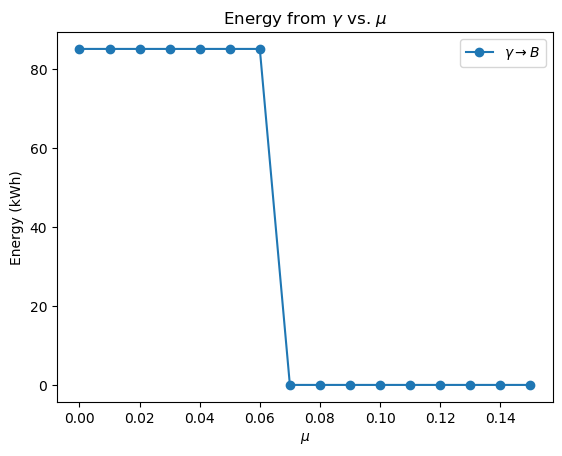


------Solution------
µ: 0.15
Total energy losses will be 444.1103976675637 kWh.
Total dirty energy used will be 394.511220043573 kWh.


PyObject <matplotlib.legend.Legend object at 0x1402c42b0>

In [34]:
# Model: case maingrid discussion
using Clp, JuMP

m_maingrid_discussion = Model(solver=ClpSolver())

# dirty power penalty
µ_range = [0:0.01:0.15;];
#Ppath = [];
Bpath = [];

@variable(m_maingrid_discussion, x[arcs, days] >= 0) # energy flow from node i to j

# Useful expressions
@expression(m_maingrid_discussion, flow_in[k in nodes, t in days], 
    sum((1-loss*distance[(i,j)])*x[(i,j), t] for (i,j) in arcs if j == k))
@expression(m_maingrid_discussion, flow_out[k in nodes, t in days], 
    sum(x[(i,j), t] for (i,j) in arcs if i == k))
@expression(m_maingrid_discussion, energy_lost, sum(loss*distance[a]*x[a, t] for a in arcs for t in days))
@expression(m_maingrid_discussion, dirty_power, sum(flow_out[:gamma, t] for t in days))
@expression(m_maingrid_discussion, net_outflow[k in nodes, t in days], flow_out[k, t] - flow_in[k, t])

@constraint(m_maingrid_discussion, power_balance[k in nodes, t in days], net_outflow[k, t] <= b[k, t])

for p in µ_range
    @objective(m_maingrid_discussion, Min, energy_lost + p*dirty_power)

    status = solve(m_maingrid_discussion)

    println("------Solution------")
    #println(getvalue(x))
    println("µ: ", p)
    println("Total energy losses will be ", getvalue(energy_lost), " kWh.")
    println("Total dirty energy used will be ", getvalue(dirty_power), " kWh.")
    #append!(Ppath, getvalue(x[(:gamma, :P), 4]))
    append!(Bpath, getvalue(x[(:gamma, :B), 4]))
end

using PyPlot

title(L"Energy from $\gamma$ vs. $\mu$")
#plot(µ_range, Ppath, "b-o")
#plot(µ_range, Bpath, "r-o")
plot(µ_range, Bpath, "-o")
xlabel(L"$\mu$")
ylabel("Energy (kWh)")
#legend([L"$\gamma\rightarrow P$", L"$\gamma\rightarrow B$"])
legend([L"$\gamma\rightarrow B$"])

## 2.3 Mathematical model **(case battery)** ##

Battery is modeled such that it has a capacity and there would be an inefficiency in charging battery and an inefficiency in using the battery power. Therefore, the overall power loss of using battery would be $(1 - \lambda_{in}\lambda_{out}x)$ when $x$ is the amount of power to be charged into the battery. And the objective of the mathematical model takes account that the battery power loss is minimized as well as other terms considered so far.

\begin{align*}
\underset{x,s}{\min} \ & \sum_{\substack{(i, j) \in Edges \\ t \in Days}}dP(x_{(i, j), t}) + \mu\sum_{\substack{(\gamma, j) \in Edges \\ t \in Days}}x_{(\gamma, j), t} + (1 - \lambda_{in}\lambda_{out})\sum_{\substack{k \in Nodes \\ t \in AddDays}}s_{k, t} \\
\text{s.t.} \ & \sum_{(i, k) \in Edges}(1 - d)P(x_{(i, k), t}) + p_{k, t} + \lambda_{out}s_{k, t} \geq \sum_{(k, j) \in Edges}x_{(k, j), t} + c_{k, t} + s_{k, t + 1} \quad\forall k \in Nodes, t \in Days \\
& s_{n, t} \leq b_{c} \quad\forall n \in Nodes, t \in Days \\
& s_{n, t + 1} \leq \lambda(\sum_{(i, k) \in Edges}(1 - d)P(x_{(i, k), t}) + p_{k, t} + s_{k, t} - (\sum_{(k, j) \in Edges}x_{(k, j), t} + c_{k, t})) \\
& x_{(i, j), t} \geq 0 \quad\forall (i, j) \in Edges, t \in Days \\
& s_{n, t} \geq 0 \quad\forall n \in Nodes, t \in Days \\
\end{align*}

This is equivalent to the following.

\begin{align*}
\underset{x,s}{\min} \ & \sum_{\substack{(i, j) \in Edges \\ t \in Days}}dP(x_{(i, j), t}) + \mu\sum_{\substack{(\gamma, j) \in Edges \\ t \in Days}}x_{(\gamma, j), t} + (1 - \lambda_{in}\lambda_{out})\sum_{\substack{k \in Nodes \\ t \in AddDays}}s_{k, t} \\
\text{s.t.} \ & -\sum_{(i, k) \in Edges}(1 - d)P(x_{(i, k), t}) - \lambda_{out}s_{k, t} + \sum_{(k, j) \in Edges}x_{(k, j), t} + s_{k, t + 1} \leq b_{k, t} \quad\forall k \in Nodes, t \in Days \\
& s_{n, t} \leq b_{c} \quad\forall n \in Nodes, t \in Days \\
& s_{n, t + 1} \leq \lambda(\sum_{(i, k) \in Edges}(1 - d)P(x_{(i, k), t}) + p_{k, t} + s_{k, t} - (\sum_{(k, j) \in Edges}x_{(k, j), t} + c_{k, t})) \\
& x_{(i, j), t} \geq 0 \quad\forall (i, j) \in Edges, t \in Days \\
& s_{n, t} \geq 0 \quad\forall n \in Nodes, t \in Days \\
\end{align*}

## 3. Solution ##

Here, you should code up your model in Julia + JuMP and solve it. Your code should be clean, easy to read, well annotated and commented, and it should compile! You are not allowed to use other programming languages or DCP packages such as `convex.jl`. **I will be running your code**. I suggest having multiple code blocks separated by text blocks that explain the various parts of your solution. You may also solve several versions of your problem with different models/assumptions.

It's fine to call external packages such as `Gurobi`, but try to minimize the use of exotic libraries.

In [ ]:
using JuMP, Clp

m = Model(solver = ClpSolver())

things = [:horses, :donkeys, :goats]  # these are the things
@variable(m, x[things] >= 0)          # the quantities of each of the things (can't be negative)
@constraint(m, sum(x) <= 10)          # we can't have any more than 10 things total
@objective(m, Max, x[:horses])        # we want to maximize the number of horses
solve(m)

for i in things
    println("The total number of ", i, " is: ", getvalue(x[i]))     # print result
end

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

 Use plots (see `PyPlot` examples from class), or you can display results in a table like this:

| Tables        | Are          | Cool  |
| ------------- |:-------------| -----:|
| col 3 is      |right-aligned |\$1600 |
|  colons       | align columns|  \$12 |
| zebra stripes |    are neat  |   \$1 |

### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.